# Image Segmentation - CPU Ver.

## 1 - Download the Dataset

In [1]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...


## 2 - Set Up the Environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/albumentations-team/albumentations to c:\users\elaine chen\appdata\local\temp\pip-req-build-quef_kqj
  Resolved https://github.com/albumentations-team/albumentations to commit 3c510e1422f6663ccd5026950af2d9ea85b5302a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\Elaine Chen\AppData\Local\Temp\pip-req-build-quef_kqj'

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys

sys.path.append('/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## 3 - Set Up Configurations

In [33]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'

# DEVICE = 'cuda' # GPU
DEVICE = torch.device('cpu') # CPU

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

# read the image as BGR format
image = cv2.imread(image_path)

# convert BGR to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

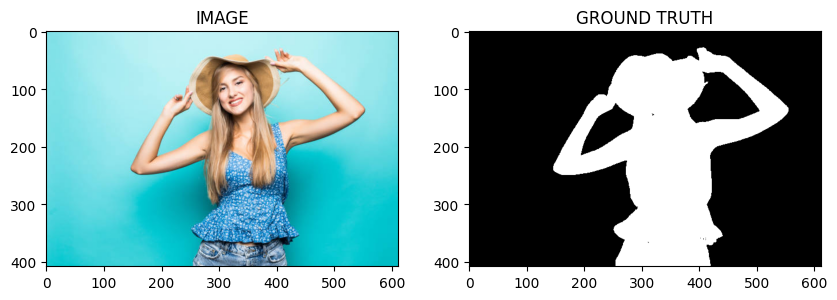

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
# Split the dataset into train and valid dataset
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

## 4 - Implement Augmentation Functions

In [10]:
import albumentations as A

In [11]:
from albumentations.core.composition import Compose
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
      ], is_check_shapes = False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      ], is_check_shapes = False)

## 5 - Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # (h, w, c) -> (height, weight, channel)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      # (h, w, c) -> (c, h, w)
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


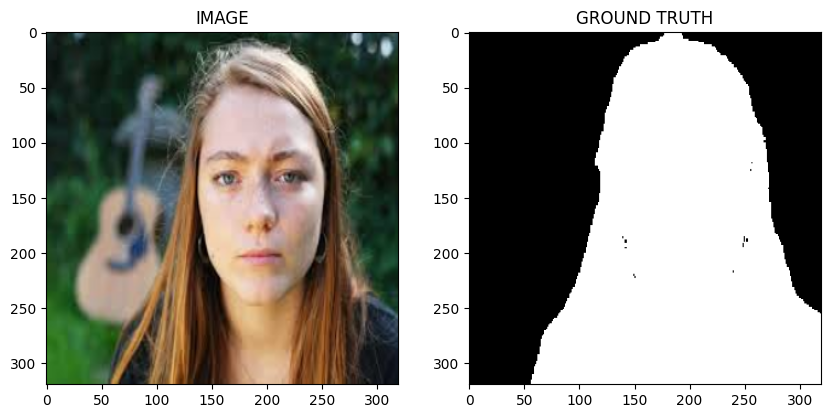

In [16]:
idx = 0

image, mask = trainset[idx]

helper.show_image(image, mask)

## 6 - Load Dataset into Batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


## 7 - Create Segmentation Model

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

C:\Users\Elaine Chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    
    return logits

In [23]:
model = SegmentationModel()
# model.to(DEVICE) # Load on GPU
MDPATH = 'best_model.pt'
torch.save(model.state_dict(), MDPATH)
model.load_state_dict(torch.load(MDPATH, map_location = DEVICE)) # Load on CPU

<All keys matched successfully>

## 8 - Create Functions for Train and Valid

In [24]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

#     images = images.to(DEVICE) # GPU
#     masks = masks.to(DEVICE) # GPU

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

#       images = images.to(DEVICE) # GPU
#       masks = masks.to(DEVICE) # GPU

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

## 9 - Train the Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [34]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), MDPATH)
    print('SAVED MODEL')
    best_valid_loss = valid_loss
  
  print(f"Epoch : {i + 1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.12s/it]


SAVED MODEL
Epoch : 1 Train_loss : 0.15069678525129954 Valid_loss : 0.16262605600059032


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.36s/it]


Epoch : 2 Train_loss : 0.16016109436750411 Valid_loss : 0.2729445546865463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.33s/it]


Epoch : 3 Train_loss : 0.15730272432168324 Valid_loss : 0.18455783650279045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.92s/it]


Epoch : 4 Train_loss : 0.18305746714274088 Valid_loss : 0.24099666997790337


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.88s/it]


Epoch : 5 Train_loss : 0.17767442166805267 Valid_loss : 0.2522723115980625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.91s/it]


Epoch : 6 Train_loss : 0.17569282700618108 Valid_loss : 0.19620266556739807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.93s/it]


Epoch : 7 Train_loss : 0.16624349256356558 Valid_loss : 0.22907058149576187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.91s/it]


Epoch : 8 Train_loss : 0.1360425665974617 Valid_loss : 0.2352524809539318


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.87s/it]


Epoch : 9 Train_loss : 0.13462914476792018 Valid_loss : 0.1787320226430893


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.01s/it]


Epoch : 10 Train_loss : 0.1299574077129364 Valid_loss : 0.23430989310145378


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.90s/it]


Epoch : 11 Train_loss : 0.10599633753299713 Valid_loss : 0.18964878842234612


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.93s/it]


Epoch : 12 Train_loss : 0.10820652147134145 Valid_loss : 0.1980721913278103


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.94s/it]


Epoch : 13 Train_loss : 0.09342707842588424 Valid_loss : 0.24457623809576035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.85s/it]


Epoch : 14 Train_loss : 0.08016280134518941 Valid_loss : 0.20914235338568687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.89s/it]


Epoch : 15 Train_loss : 0.08090323383609453 Valid_loss : 0.17846253514289856


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.89s/it]


Epoch : 16 Train_loss : 0.08070626705884934 Valid_loss : 0.20239828526973724


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.96s/it]


Epoch : 17 Train_loss : 0.07311104064186415 Valid_loss : 0.19937415793538094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.05s/it]


Epoch : 18 Train_loss : 0.07613464295864106 Valid_loss : 0.17495455592870712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.23s/it]


Epoch : 19 Train_loss : 0.0695516233642896 Valid_loss : 0.18403125554323196


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]


Epoch : 20 Train_loss : 0.0678717980782191 Valid_loss : 0.18645594269037247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.38s/it]


Epoch : 21 Train_loss : 0.06550523216525714 Valid_loss : 0.20940547436475754


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.95s/it]


Epoch : 22 Train_loss : 0.06354335124293962 Valid_loss : 0.20264111459255219


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch : 23 Train_loss : 0.1071009027461211 Valid_loss : 0.2791092321276665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch : 24 Train_loss : 0.1652253622810046 Valid_loss : 0.2861352562904358


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.93s/it]

Epoch : 25 Train_loss : 0.15801456620295842 Valid_loss : 0.2099091038107872


## 10 - Inference

In [35]:
validset.df.shape

(58, 2)

In [38]:
idx = 20

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

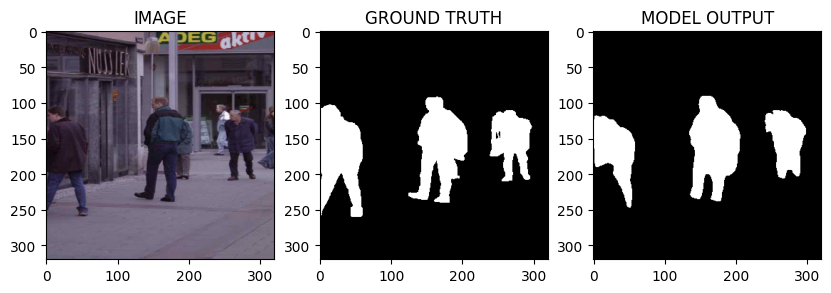

In [39]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))